https://dacon.io/competitions/official/236056/overview/description

In [75]:
# ID : 음악 샘플 고유 ID
# 음악 샘플의 특징 정보
# danceability
# energy
# key
# loudness
# speechiness
# acousticness 
# instrumentalness
# liveness
# valence
# tempo
# duration : 음악 재생 시간(길이) (초)
# genre : 음악 장르 (총 15개 종류)

In [76]:
import pandas as pd
import torch
import torch.nn as nn

from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import numpy as np
from tqdm import tqdm
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
%matplotlib inline

np.random.seed(0)

In [78]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train

,ID,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,genre
0,TRAIN_00000,0.3341,0.9231,10,0.8540,0.3797,0.0080,0.0002,0.7697,0.7902,0.5391,175,trap
1,TRAIN_00001,0.6344,0.5955,10,0.2826,0.1378,0.0000,0.7137,0.1597,0.4162,0.3043,513,techno
2,TRAIN_00002,0.3983,0.1107,8,0.2459,0.0247,0.7740,0.0000,0.5105,0.4291,0.2324,151,Trap Metal
3,TRAIN_00003,0.3139,0.9702,2,0.9252,0.9590,0.0371,0.3015,0.2539,0.0577,0.5406,246,trap
4,TRAIN_00004,0.0735,0.9452,5,0.7702,0.1397,0.2583,0.0015,0.1774,0.1128,0.3176,229,Dark Trap
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25378,TRAIN_25378,0.8814,0.3398,6,0.4602,0.3825,0.4505,0.0000,0.4222,0.8753,0.4081,88,Underground Rap
25379,TRAIN_25379,0.7505,0.5657,0,0.6682,0.1038,0.1281,0.0000,0.0596,0.9583,0.4273,123,Trap Metal
25380,TRAIN_25380,0.2520,0.7617,8,0.4928,0.0410,0.0003,0.8395,0.0843,0.1372,0.7828,353,dnb
25381,TRAIN_25381,0.6202,0.3455,0,0.6499,0.7960,0.4818,0.0000,0.2007,0.0194,0.9756,120,Dark Trap


In [79]:
# 라벨 인코딩
encoder = LabelEncoder()
train['genre'] = encoder.fit_transform(train['genre'])

In [80]:
train_targets = train[['genre']]
train = train.drop(columns='genre')

In [81]:
col_name = list(train.columns)
print(col_name)

['ID', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']


In [82]:
np.random.seed(42)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [84]:
unused_feat = ['Set', 'sig_id', 'ID'] # Let's not use splitting sets and sig_id

features = [ col for col in train.columns if col not in unused_feat] 

In [85]:
X_train = train[features].values[train_indices]
y_train = train_targets.values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train_targets.values[valid_indices]

In [86]:
clf = TabNetMultiTaskClassifier(n_steps=1,
                                cat_emb_dim=1,
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":50, # how to use learning rate scheduler
                                                  "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax', # "sparsemax",
                                lambda_sparse=0, # don't penalize for sparser attention
                       
                      )

C:\Users\roy57\AppData\Roaming\Python\Python39\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [87]:
max_epochs = 1000
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_valid, y_valid)],
    max_epochs=max_epochs ,
    patience=50, # please be patient ^^
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=1,
    drop_last=False,
)

# scores displayed here are -average of log loss

# TabNet is not as fast as XGBoost (at least for binary classification and regression problems)
# If you wish to speed things up you could play with batch_size, virtual_batch_size and num_workers (or create a smaller network with less steps)
# Another way to speed things up is to improve the source code : please contribute here https://github.com/dreamquark-ai/tabnet/issues/183

epoch 0  | loss: 2.51542 | val_0_logloss: 2.60347 |  0:00:06s
epoch 1  | loss: 2.06476 | val_0_logloss: 4.1301  |  0:00:11s
epoch 2  | loss: 1.66191 | val_0_logloss: 3.10112 |  0:00:17s
epoch 3  | loss: 1.40444 | val_0_logloss: 2.96175 |  0:00:23s
epoch 4  | loss: 1.26596 | val_0_logloss: 3.45438 |  0:00:29s
epoch 5  | loss: 1.20747 | val_0_logloss: 3.26691 |  0:00:35s
epoch 6  | loss: 1.17861 | val_0_logloss: 2.95695 |  0:00:41s
epoch 7  | loss: 1.14042 | val_0_logloss: 2.8199  |  0:00:47s
epoch 8  | loss: 1.13356 | val_0_logloss: 2.47449 |  0:00:52s
epoch 9  | loss: 1.10503 | val_0_logloss: 2.26263 |  0:00:58s
epoch 10 | loss: 1.08541 | val_0_logloss: 2.04459 |  0:01:04s
epoch 11 | loss: 1.07009 | val_0_logloss: 1.85018 |  0:01:10s
epoch 12 | loss: 1.06551 | val_0_logloss: 1.8116  |  0:01:16s
epoch 13 | loss: 1.05277 | val_0_logloss: 1.58787 |  0:01:22s
epoch 14 | loss: 1.04562 | val_0_logloss: 1.3748  |  0:01:27s
epoch 15 | loss: 1.04218 | val_0_logloss: 1.37779 |  0:01:33s
epoch 16

C:\Users\roy57\AppData\Roaming\Python\Python39\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


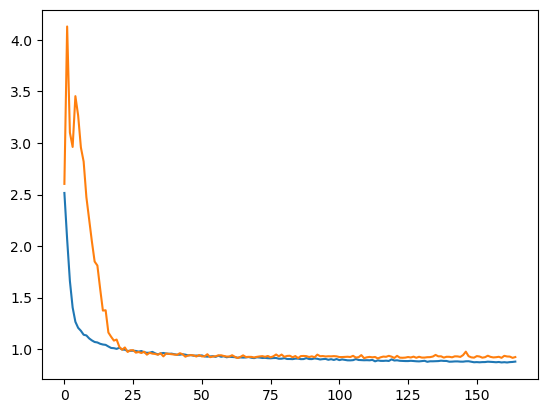

In [88]:
# plot losses (drop first epochs to have a nice plot)
plt.plot(clf.history['loss'])
plt.plot(clf.history['val_0_logloss'])

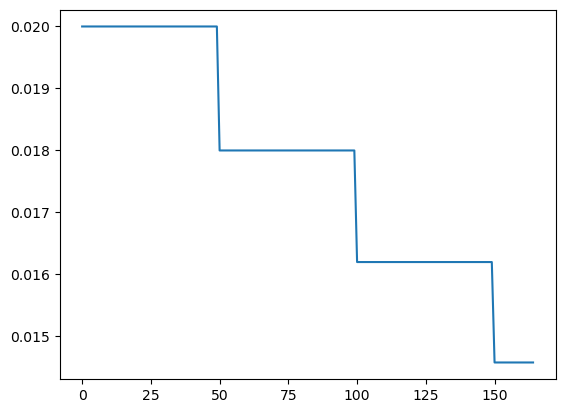

In [89]:
# plot learning rates
plt.plot([x for x in clf.history['lr']])

In [90]:
pred = clf.predict(X_valid)
pred = pd.DataFrame(pred[0]).rename(columns = {0:'genre'})
pred['genre'] = pred['genre'].astype('int')
pred

,genre
0,12
1,12
2,14
3,7
4,7
...,...
5088,7
5089,11
5090,8
5091,2


In [91]:
y_valid = pd.DataFrame(y_valid).rename(columns = {0:'genre'})
y_valid['genre'] = y_valid['genre'].astype('int')
y_valid

,genre
0,12
1,12
2,5
3,7
4,7
...,...
5088,7
5089,11
5090,8
5091,5


In [92]:
# 모델 스코어 확인
from sklearn.metrics import f1_score
print('score:' , f1_score(y_valid, pred, average='macro'))

score: 0.6394742358842402


제출용

In [137]:
test = pd.read_csv('test.csv')
test

,ID,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
0,TEST_00000,0.8861,0.6821,2,0.7241,0.3103,0.1451,0.0000,0.5087,0.8863,0.9648,279
1,TEST_00001,0.8495,0.3883,1,0.4495,0.4661,0.6234,0.0004,0.1347,0.4062,0.9051,151
2,TEST_00002,0.2479,0.7549,3,0.7683,0.3131,0.5718,0.0000,0.1250,0.6357,0.3234,196
3,TEST_00003,0.6344,0.9804,1,0.6599,0.0931,0.0020,0.6016,0.8799,0.8790,0.2946,207
4,TEST_00004,0.6237,0.6926,6,0.6716,0.0269,0.0283,0.0001,0.1580,0.9288,0.3642,196
...,...,...,...,...,...,...,...,...,...,...,...,...
16917,TEST_16917,0.5461,0.8686,1,0.6351,0.0656,0.0010,0.8888,0.0047,0.8250,0.2672,161
16918,TEST_16918,0.8443,0.4194,4,0.5065,0.4315,0.1637,0.0241,0.0749,0.9482,0.9186,289
16919,TEST_16919,0.3373,0.9202,10,0.7272,0.4502,0.0791,0.0001,0.1881,0.0992,0.5953,212
16920,TEST_16920,0.4017,0.9741,9,0.6272,0.0768,0.0001,0.8718,0.6649,0.4463,0.4841,617


In [138]:
test_id = test['ID']
test = test.drop(columns='ID')

In [139]:
X_test = test[features].values

In [140]:
test_pred = clf.predict(X_test)
test_pred = test_pred[0]
test_pred = test_pred.astype(int)
test_pred

array([ 2,  7,  7, ...,  9, 10,  7])

In [142]:
y_test_pred = encoder.inverse_transform(test_pred)
y_test_pred

array(['Hiphop', 'Underground Rap', 'Underground Rap', ..., 'hardstyle',
       'psytrance', 'Underground Rap'], dtype=object)

In [143]:
y_test_pred = pd.DataFrame(y_test_pred).rename(columns = {0:'genre'})
y_test_pred

,genre
0,Hiphop
1,Underground Rap
2,Underground Rap
3,techhouse
4,Pop
...,...
16917,techhouse
16918,Hiphop
16919,hardstyle
16920,psytrance


In [144]:
final = pd.concat([test_id, y_test_pred],axis=1)
final

,ID,genre
0,TEST_00000,Hiphop
1,TEST_00001,Underground Rap
2,TEST_00002,Underground Rap
3,TEST_00003,techhouse
4,TEST_00004,Pop
...,...,...
16917,TEST_16917,techhouse
16918,TEST_16918,Hiphop
16919,TEST_16919,hardstyle
16920,TEST_16920,psytrance


In [145]:
final.to_csv('submission_tabnet.csv',index=False)
pd.read_csv('submission_tabnet.csv')

,ID,genre
0,TEST_00000,Hiphop
1,TEST_00001,Underground Rap
2,TEST_00002,Underground Rap
3,TEST_00003,techhouse
4,TEST_00004,Pop
...,...,...
16917,TEST_16917,techhouse
16918,TEST_16918,Hiphop
16919,TEST_16919,hardstyle
16920,TEST_16920,psytrance


In [ ]:
# final.to_csv('submission.csv',index=False)
# pd.read_csv('submission.csv')